In [1]:
using ZipFile, Distributed, CSV, DataFrames, Random, StatsBase, Plots, Statistics, StableRNGs, MLJBase
using Flux
using Flux: logitbinarycrossentropy
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using BSON: @save
using Distributions
using Plots
using LaTeXStrings
using Evolutionary
using MLDatasets

file = CSV.read("train.csv", DataFrame)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep
,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64
1,842,0,2.2,0,1,0,7,0.6
2,1021,1,0.5,1,0,1,53,0.7
3,563,1,0.5,1,2,1,41,0.9
4,615,1,2.5,0,0,0,10,0.8
5,1821,1,1.2,0,13,1,44,0.6
6,1859,0,0.5,1,3,0,22,0.7
7,1821,0,1.7,0,4,1,10,0.8
8,1954,0,0.5,1,0,0,24,0.8
9,1445,1,0.5,0,0,0,53,0.7


In [2]:
# Transfer DataFrame to matrix form
df = file |> Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

mat_0 = df[df[:,21] .<= 1, :]
mat_1 = df[df[:,21] .>= 2, :]


1000×21 Matrix{Float64}:
 1021.0  1.0  0.5  1.0   0.0  1.0  53.0  …   3.0   7.0  1.0  1.0  0.0  2.0
  563.0  1.0  0.5  1.0   2.0  1.0  41.0      2.0   9.0  1.0  1.0  0.0  2.0
  615.0  1.0  2.5  0.0   0.0  0.0  10.0      8.0  11.0  1.0  0.0  0.0  2.0
 1821.0  0.0  1.7  0.0   4.0  1.0  10.0      8.0  18.0  1.0  0.0  1.0  3.0
  769.0  1.0  2.9  1.0   0.0  0.0   9.0      2.0   7.0  0.0  0.0  0.0  3.0
 1520.0  1.0  2.2  0.0   5.0  1.0  33.0  …   9.0  13.0  1.0  1.0  1.0  3.0
  803.0  1.0  2.1  0.0   7.0  0.0  17.0      1.0   4.0  1.0  0.0  1.0  2.0
  838.0  0.0  0.5  0.0   1.0  1.0  13.0      9.0  19.0  1.0  0.0  1.0  3.0
  595.0  0.0  0.9  1.0   7.0  1.0  23.0      2.0  18.0  1.0  1.0  0.0  3.0
  772.0  0.0  1.1  1.0  12.0  0.0  39.0     15.0   3.0  1.0  1.0  0.0  3.0
 1709.0  1.0  2.1  0.0   1.0  0.0  13.0  …   1.0  15.0  1.0  0.0  0.0  3.0
  961.0  1.0  1.4  1.0   0.0  1.0  57.0      9.0   7.0  1.0  1.0  1.0  2.0
  519.0  1.0  1.6  1.0   7.0  1.0  51.0      1.0   4.0  1.0  0.0  1.0  3.0


In [3]:
# randomly select 70% data from data set as the train data

train_data = randsubseq(1:1000, 0.7)
train_df = vcat(mat_0[train_data, :], mat_1[train_data, :])

# select the rest as the test data 

test_data = [i for i in 1:1000 if isempty(searchsorted(train_data, i))]
test_df = vcat(mat_0[test_data, :], mat_1[test_data, :])

574×21 Matrix{Float64}:
 1821.0  1.0  1.2  0.0  13.0  1.0  44.0  …   2.0  15.0  1.0  1.0  0.0  1.0
 1954.0  0.0  0.5  1.0   0.0  0.0  24.0      3.0   5.0  1.0  1.0  1.0  0.0
 1445.0  1.0  0.5  0.0   0.0  0.0  53.0      1.0  20.0  1.0  0.0  0.0  0.0
  509.0  1.0  0.6  1.0   2.0  1.0   9.0     10.0  12.0  1.0  0.0  0.0  0.0
 1815.0  0.0  2.8  0.0   2.0  0.0  33.0      0.0   2.0  1.0  0.0  0.0  1.0
  775.0  0.0  1.0  0.0   3.0  0.0  46.0  …  15.0  11.0  1.0  1.0  1.0  0.0
 1131.0  1.0  0.5  1.0  11.0  0.0  49.0     13.0  16.0  1.0  1.0  0.0  1.0
  644.0  1.0  2.7  0.0   0.0  0.0  22.0      1.0  15.0  1.0  0.0  0.0  0.0
 1253.0  1.0  0.5  1.0   5.0  1.0   5.0      0.0   4.0  1.0  1.0  0.0  1.0
 1054.0  1.0  1.8  1.0   3.0  1.0  40.0     12.0  12.0  1.0  0.0  1.0  1.0
  578.0  1.0  2.6  1.0   2.0  1.0  57.0  …   3.0   5.0  1.0  0.0  1.0  0.0
 1457.0  0.0  1.9  1.0   1.0  1.0  16.0      8.0  12.0  1.0  0.0  1.0  1.0
  823.0  1.0  2.7  1.0  13.0  0.0  60.0     11.0  17.0  1.0  1.0  1.0  0.0
 

In [4]:
# parameters of the training and testing data
para_train = train_df[:, 1:20]
para_test = test_df[:, 1:20]

# value is never used?
value_train = train_df[:, 21]
value_test = test_df[:, 21]
value_train_std = reshape(value_train, (1, :)) 
value_test_std = reshape(value_test, (1, :)) 


1×574 Matrix{Float64}:
 1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  …  2.0  2.0  2.0  3.0  3.0  3.0  3.0

In [5]:
dt = StatsBase.fit(ZScoreTransform, para_train, dims=1)

# rotate the matrix for 90 degree
para_train_std = StatsBase.transform(dt, para_train)
para_test_std = StatsBase.transform(dt, para_test)

para_train_std = transpose(para_train_std) 
para_test_std = transpose(para_test_std)

20×574 transpose(::Matrix{Float64}) with eltype Float64:
  1.33419     1.63546    0.482486  …  -0.847172   1.53806   -1.63545
  1.01804    -0.981586   1.01804      -0.981586  -0.981586   1.01804
 -0.391419   -1.24098   -1.24098       0.822244  -0.755518   0.579511
 -1.01947     0.98021   -1.01947      -1.01947    0.98021    0.98021
  1.98008    -1.01663   -1.01663      -0.786117  -0.786117   0.13595
  0.954405   -1.04704   -1.04704   …  -1.04704    0.954405   0.954405
  0.6546     -0.447803   1.15068       0.985321   0.213639   0.70972
  0.344832    1.04381    0.69432      -1.40261    0.69432    1.3933
  0.0182138   1.32395    0.954939     -1.59977   -0.918511   0.784625
 -1.08127    -0.205942   1.10705      -1.51894    1.54472    0.669389
  0.678773   -1.65198    0.678773  …  -1.31902   -1.15254    1.01174
  1.26957    -0.29681   -0.580379     -0.260802   0.504385  -0.362076
 -0.11402    -0.259651  -0.983186      0.357549   0.856858  -1.17274
 -0.675366   -1.33374   -0.964272      1.7

In [6]:
const Float = Float64


"""
    Particle type
`nDim::Int`: dimension of the parameter space to be explored
`position::Array{Float, 1}`: current position of the particle
`velocity::Array{Float, 1}`: current velocity of the particle
`pBest::Array{Float, 1}`: the position at which the particle has 
the best-fit value through particle's history
`lBest::Array{Float, 1}`: the position at which the local group has 
the best-fit value through local group's history
`fitValue::Float`: the fit-value at current position
`fitpBest::Float`: the fit-value at `pBest`
`fitlBest::Float`: the fit-value at `lBest`
`nFitEval::Int`: number of the evaluation of the fitness function 
(which does not take the steps outside the parameter space into account)
"""
mutable struct Particle
    nDim::Int
    
    position::Array{Float, 1}
    velocity::Array{Float, 1}
    pBest::Array{Float, 1}
    lBest::Array{Float, 1}
    
    fitValue::Float
    fitpBest::Float
    fitlBest::Float
    
    nFitEval::Int
    
    # initialize the particle
    # with the lBest = pBest = position = random numbers
    # and fitlBest = fitpBest = fitValue = Inf
    # These setups will be updated by the initiation of the swarm
    function Particle(nDim::Int)
        position = rand(nDim)
        velocity = rand(nDim) - position
        pBest = position
        lBest = position
        
        fitValue = Inf
        fitpBest = fitValue
        fitlBest = fitValue
        
        nFitEval = 0
        
        new(nDim, position, velocity, pBest, lBest, 
            fitValue, fitpBest, fitlBest, nFitEval)
    end       
end

# test
# p1 = Particle(4)

Particle

In [7]:
"""
    initFitValue!(fitFunc::Function, p::Particle)
Initiate the `fitValue` for the `p` particle using the fitness 
function `fitFunc`.
"""
function initFitValue!(fitFunc::Function, p::Particle)
    # p.fitValue = fitFunc(p.position)
    θ, re = Flux.destructure(base_model)
    p.position = θ
    p.fitValue = fitFunc(p.position,re)
    
    # update nFitEval
    p.nFitEval += 1
    nothing
end


initFitValue!

In [8]:
"""
    updatePositionAndFitValue!(fitFunc::Function, nDim::Int, p::Particle)
Update the `position` and `fitValue` for the `p` particle using 
the fitness function `fitFunc` with `nDim` parameters.
"""
function updatePositionAndFitValue!(fitFunc::Function, p::Particle)
    p.position += p.velocity
    
    # if position is outside the paramter space, we set fitValue = Inf
    for x in p.position
        if (x < 0 || x > 1)
            p.fitValue = Inf
            return
        end
    end
    # update nFitEval
    θ, re = Flux.destructure(base_model)
    p.fitValue = fitFunc(p.position,re)

    
    nothing
end


updatePositionAndFitValue!

In [32]:
"""
    updatepBestAndFitpBest!(p::Particle)
Update the `pBest` and `fitpBest` for `p` particle.
"""
function updatepBestAndFitpBest!(p::Particle)
    if p.fitValue < p.fitpBest 
        # θ, re = Flux.destructure(base_model)
        # base_model=re(p.pBest)
        p.fitpBest  = p.fitValue
        p.pBest = p.position
    end
    nothing
end


updatepBestAndFitpBest!

In [33]:
"""
    updateVelocity!(p::Particle, w::Float, c1::Float=c1, c2::Float=c2)
Update the `velocity` of the particle.
"""
function updateVelocity!(p::Particle, w::Float, c1::Float, c2::Float)
    p.velocity = w * p.velocity + 
    c1 * rand() * (p.pBest - p.position) + 
    c2 * rand() * (p.lBest - p.position)
    
    nothing
end

updateVelocity!

In [11]:
"""
    neiborIndices(i::Int, nNeighbor::Int, nParticle::Int)
Return the indices for the `nNeighbor` neiborhoods of the `i`th particle
in a swarm with `nParticle` particles.
"""
function neiborIndices(i::Int, nNeibor::Int, nParticle::Int)
    
    # number of neighbors should be larger than 3
    nNeibor = max(3, nNeibor)
    
    # number of neighbors on the left side of i-th particle
    nLeft = (nNeibor - 1) ÷ 2
    
    # the index of the starting particle in the local group
    startIndex = (i - nLeft)
    
    # the index of the ending particle in the local group
    endIndex = startIndex + nNeibor -1
    
    # indices for the local group
    indices = collect(startIndex:endIndex)
    
    # ajust the indices to be in the range(1:nParticle)
    for i in 1:nNeibor
        if indices[i] < 1
            indices[i] += nParticle
        elseif indices[i] > nParticle
            indices[i] -= nParticle
        end
    end
    
    indices
end

neiborIndices

In [12]:
mutable struct Swarm
    fitFunc::Function
    nDim::Int
    
    nParticle::Int
    nNeibor::Int
    nInter::Int
    
    c1::Float
    c2::Float
    
    wMax::Float
    wMin::Float
    w::Float
    
    gBest::Array{Float, 1}    
    fitgBest::Float
    
    particles::Array{Particle, 1}
    
    nFitEvals::Int
    
    # initialize the swarm
    function Swarm(fitFunc::Function, nDim::Int; 
            nParticle::Int=40, 
            nNeibor::Int=3, nInter::Int=2000,
            c1::Float=2.0, c2::Float=2.0,
            wMax::Float=0.9, wMin::Float=0.4)
        
        if nNeibor > nParticle
            error("Number of particles in a local group should not exceed 
                the totoal number of particles in the swarm!")
        end    
        
        w = wMax
        
        gBest = rand(nDim)
        fitgBest = Inf
        
        # initialize the swarm with nParticle
        particles = [Particle(nDim) for i in 1:nParticle]
        
        
        nFitEvals = 0
                
        new(fitFunc, nDim, nParticle, nNeibor, nInter, 
            c1, c2, wMax, wMin, w, gBest, 
            fitgBest, particles, nFitEvals)        
    end       
end


In [13]:
function updatelBestAndFitlBest!(s::Swarm)
    for i in 1:s.nParticle
        neiborIds = neiborIndices(i, s.nNeibor, s.nParticle)
        neiborFits = [s.particles[Id].fitValue for Id in neiborIds]
        fitlBest, index = findmin(neiborFits)
        
        if fitlBest < s.particles[i].fitlBest
            # neibor == local group
            lBest = s.particles[neiborIds[index]].position
            s.particles[i].lBest = lBest
            s.particles[i].fitlBest = fitlBest
        end
    end
    nothing
end


updatelBestAndFitlBest! (generic function with 1 method)

In [14]:
function updategBestAndFitgBest!(s::Swarm)
    
    gFits = [particle.fitValue for particle in s.particles]
    fitgBest, index = findmin(gFits)
    if fitgBest < s.fitgBest
        s.gBest = s.particles[index].position   
        s.fitgBest = fitgBest
    end
    nothing
end

updategBestAndFitgBest! (generic function with 1 method)

In [15]:
"""
    initSwarm(s::Swarm)
Initiation (0st iteration) the swarm `s`.
"""
function initSwarm(s::Swarm)
    
    # initiate the fitValue for each particle
    for particle in s.particles
        initFitValue!(s.fitFunc, particle)
        updatepBestAndFitpBest!(particle)
    end
    
    # update lBest and fitlBest for the swarm
    updatelBestAndFitlBest!(s)
    
    # update gBest and fitgBest for the swarm
    updategBestAndFitgBest!(s)
    
    nothing
end

initSwarm

In [16]:
"""
    updateInertia!(s::Swarm)
Update the inertia weight after each iteration.
"""
function updateInertia!(s::Swarm)
    dw = (s.wMax - s.wMin)/s.nInter
    s.w -= dw
    
    nothing
end

updateInertia!

In [17]:
"""
    updateVelocity!(s::Swarm)
Update the `velocity` for each particle in the swarm `s`.
"""
function updateVelocity!(s::Swarm)
    for particle in s.particles
        updateVelocity!(particle, s.w, s.c1, s.c2)
    end        
    nothing
end


updateVelocity!

In [18]:
"""
    updatePositionAndFitValue!(s::Swarm)
Update the `position` and `fitValue` for each particle in the swarm `s`.
"""
function updatePositionAndFitValue!(s::Swarm)
    for particle in s.particles
        updatePositionAndFitValue!(s.fitFunc, particle)
    end        
    nothing
end

updatePositionAndFitValue!

In [19]:
"""
    updateSwarm(s::Swarm)
One iteration for the swarm `s`.
"""
function updateSwarm(s::Swarm)
    # update the velocity for each particle in the swarm
    updateVelocity!(s::Swarm)
    
    # update the position and fitValue for each particle in the swarm
    updatePositionAndFitValue!(s::Swarm)
    
    # update the lBest and fitlBest for each particle in the swarm
    updatelBestAndFitlBest!(s::Swarm)
    
    # update the gBest and fitgBest for the swarm
    updategBestAndFitgBest!(s::Swarm) 
    
    # update the inertia weigh w for each particle in the swarm
    updateInertia!(s::Swarm)
    
    nothing 
end

updateSwarm

In [22]:
# basic parameters
batch_size = 20
# population_size = 300
population_size = 30
Mutation_rate = 0.5
recombination_rate = 0.4
Retain_rate = 0.9
iteration = 500
layer = 2

2

In [23]:
base_model = Chain(Dense(batch_size, 12, relu), Dense(12, 1, relu))

Chain(
  Dense(20, 12, relu),                  # 252 parameters
  Dense(12, 1, relu),                   # 13 parameters
)                   # Total: 4 arrays, 265 parameters, 1.285 KiB.

In [29]:
θ, re = Flux.destructure(base_model)

# θ


# return 1, 2

# one, two = myfun()

(Float32[0.19442172, -0.25658572, 0.40864733, 0.35167807, -0.36398262, -0.4163681, 0.18964973, -0.3573194, 0.18644026, 0.38582742  …  -0.12688942, 0.017137771, 0.37018353, -0.51629823, -0.2204045, -0.44497353, 0.2534936, 0.18262596, -0.13837075, 0.0], Flux.var"#62#64"{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}}}}(Chain(Dense(20, 12, relu), Dense(12, 1, relu))))

In [34]:
function onePsoRun(fitFunc::Function, nDim::Int; nParticle=100, nInter::Int=4000)
    s = Swarm(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
    initSwarm(s)
    
    for i in s.nInter
        updateSwarm(s)
    end
    s.gBest
end

fitFunc(θ,re) = mean(vec(re(θ)(para_train_std).>0.5).==value_train_std)
nDim = 265 

nParticle = 100
nInter = 40
nRun = 20
# xs = Array{Float}(undef, nRun)
xs = []
ys = zeros(nRun)

θ, re = Flux.destructure(base_model)

for i in 1:nRun
    # onePsoRun has no return?
    xs = onePsoRun(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
    # what does xs means here?
    ys[i] = mean(re(xs)(para_train_std))
end

In [35]:
ys

20-element Vector{Float64}:
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754
 0.19319337227976754

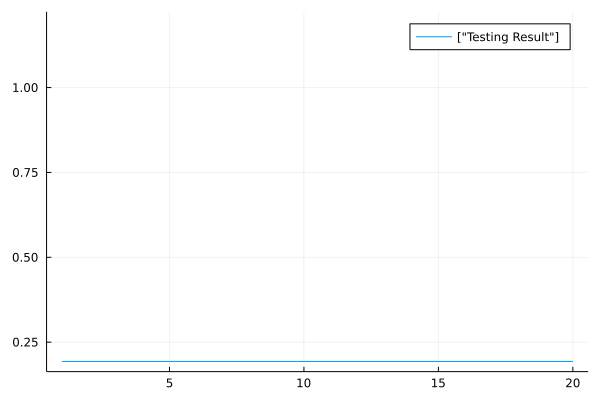

In [42]:
# Plots.plot(train_acc_list,label=["Training Result"])
Plots.plot!(ys,label=["Testing Result"])

In [45]:
"""
    In order to compute for confusion matrix
"""
#TT
TT=sum(vec(base_model(para_test_std) .> 0.5) .== 1)
#TF
TF=sum(vec(base_model(para_test_std) .> 0.5) .== 0)
#FT
FT=sum(vec(base_model(para_test_std) .< 0.5) .== 1)
#FF
FF=sum(vec(base_model(para_test_std) .< 0.5) .== 0)
println("confusion matrix:")
println("True True Result: $TT,  True False Result: $TF")
println("False False Result: $FF,   False True Result: FT")

confusion matrix:
True True Result: 103,  True False Result: 471
False False Result: 103,   False True Result: FT
